# how many parameters is "enough"?

### During these excersizes, we have seen a traditional parameter estimation then uncertainty analysis workflow.  We also saw for the pilot points notebooks, about 500 model runs to "calibrate" the model and then another 500 to 1000 to find a decent set (ensemble) of realizations that fit the data acceptably well.  

### But...even using pilot points as a parameterization device is a form of regularization: ideally, we would have an HK parameter in every model cell. But, that is too expensive in terms of model runs for calibration and uncertainty analysis (at least as we have learned it so far).

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_gr()
working_dir = fs.WORKING_DIR_GR
pst_name = fs.PST_NAME_GR


changing model workspace...
   freyberg_gr
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_ies/freyberg_gr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/21 19:51:18

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/10/21 19

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:1607: PyemuWarning: Flow out (flout) of grouped segments will be aggregated... 
  warnings.warn("Flow out (flout) of grouped segments will be aggregated... ", PyemuWarning)


writing 'sfr_obs.config' to sfr_obs.config
                                    obsnme     obsval  weight    obgnme
c001fr05c04_19791231  c001fr05c04_19791231  29.135645     0.0  forehead
c001fr16c17_19791231  c001fr16c17_19791231  21.775225     0.0  forehead
noptmax: 0
noptmax: 8


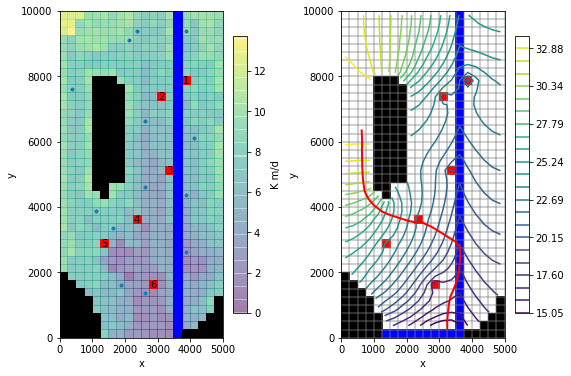

In [3]:
fs.plot_model(working_dir, pst_name)

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
"number of parameters: {0} : WTF!".format(pst.npar)

'number of parameters: 4852 : WTF!'

In [5]:
#par = pst.parameter_data
#par.loc[par.pargp=="hk","partrans"] = "none"
#par.loc[par.pargp=="hk","parubnd"] = 15.0
#par

[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

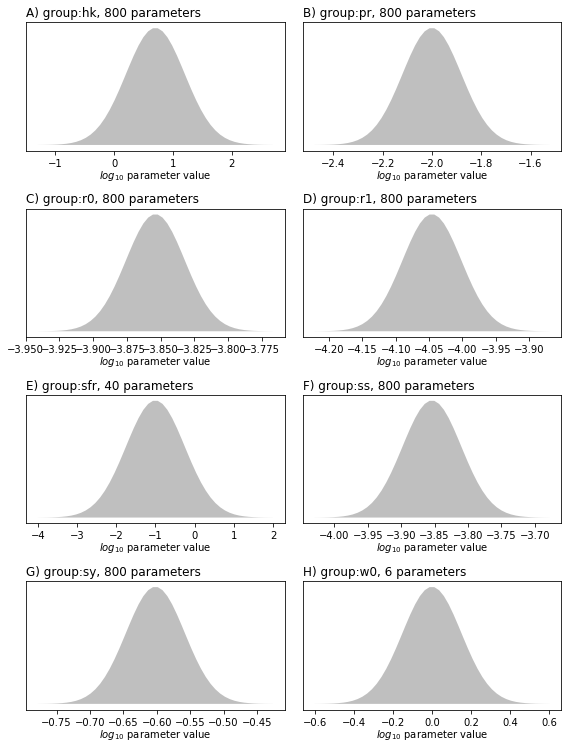

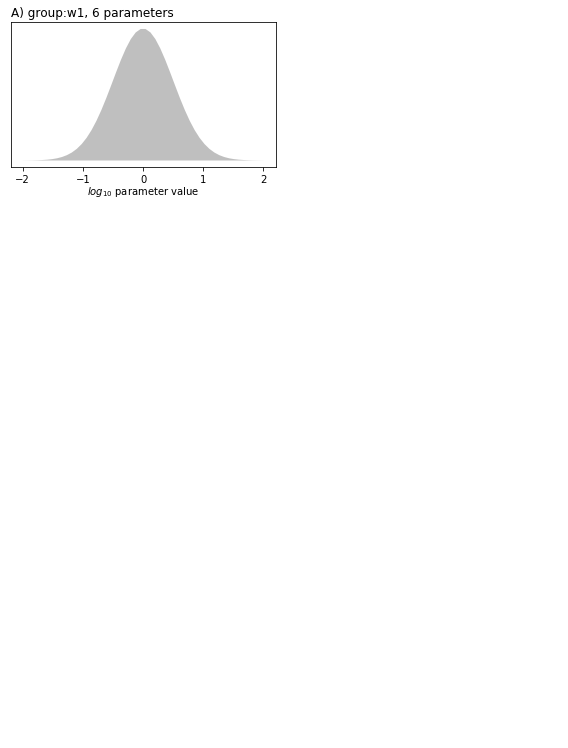

In [6]:
pst.plot(kind="prior",unique_only=True)

In [7]:
pst.pestpp_options["ies_subset_size"] = 5
pst.pestpp_options["ies_num_reals"] = 30
pst.pestpp_options["ies_lambda_mults"] = [0.01,1.0,10.0]
#pst.pestpp_options["parcov_filename"] = "prior.cov"
pst.pestpp_options["lambda_scale_fac"] = [0.95,1.1]
pst.control_data.noptmax = 4
pst.write(os.path.join(working_dir,pst_name))

noptmax: 4


In [8]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves(".","pestpp-ies",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

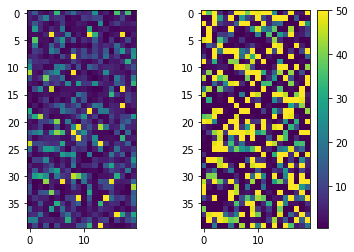

In [9]:
it = 4
realization = "1"
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
par = pst.parameter_data

init_par = pst.filename.replace(".pst",".0.par.csv")
final_par = pst.filename.replace(".pst",".{0}.par.csv".format(it))
init_par = pd.read_csv(init_par,index_col=0)
init_par.columns = init_par.columns.str.lower()
final_par = pd.read_csv(final_par,index_col=0)
final_par.columns = final_par.columns.str.lower()
gr_par = par.loc[par.pargp=="hk",:].copy()
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
gr_par.loc[:,"parval1"] = init_par.loc[realization,gr_par.parnme]
mn,mx = gr_par.parval1.min(),gr_par.parval1.max()
ax1,ax2 = plt.subplot(121),plt.subplot(122)
arr = np.zeros((m.nrow,m.ncol))
arr[gr_par.i,gr_par.j] = gr_par.parval1
c = ax1.imshow(arr,vmin=mn,vmax=mx)
#plt.colorbar(c)
gr_par.loc[:,"parval1"] = final_par.loc[realization,gr_par.parnme]
arr = np.zeros((m.nrow,m.ncol))
arr[gr_par.i,gr_par.j] = gr_par.parval1
c = ax2.imshow(arr,vmin=mn,vmax=mx)
plt.colorbar(c)

<Figure size 576x756 with 0 Axes>

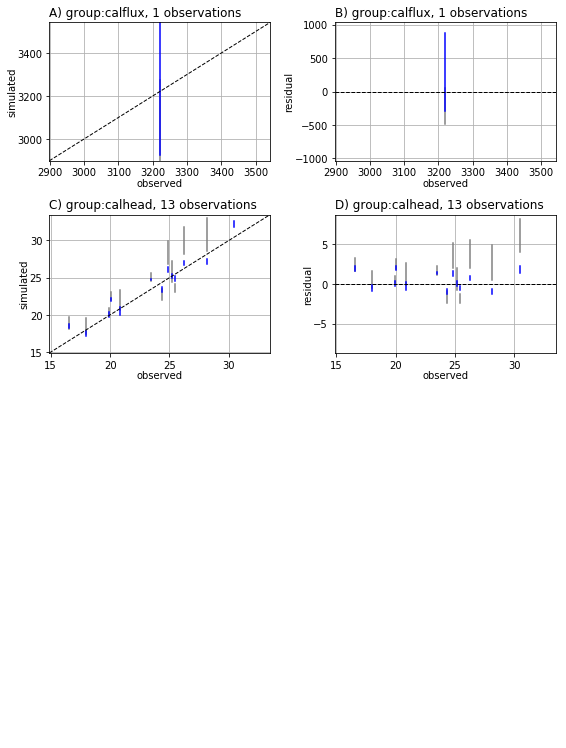

<Figure size 576x756 with 0 Axes>

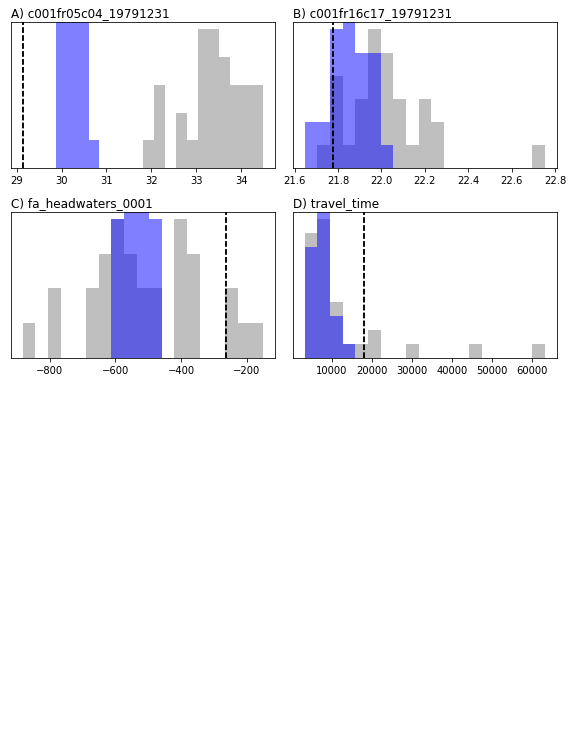

In [10]:
init_obs = pst.filename.replace(".pst",".0.obs.csv")
#pick which interation results to visualize
it = 4
final_obs = init_obs.replace("0","{0}".format(it)) 
init_df = pd.read_csv(init_obs,index_col=0)
init_df.columns = init_df.columns.map(str.lower)
final_df = pd.read_csv(final_obs,index_col=0)
final_df.columns = final_df.columns.map(str.lower)
fig = pyemu.plot_utils.ensemble_res_1to1({'0.5':init_df,"b":final_df},pst=pst)
pyemu.plot_utils.ensemble_helper({"0.5":init_df.loc[:,pst.forecast_names],"b":final_df.loc[:,pst.forecast_names]},
                                 deter_vals=pst.observation_data.loc[pst.forecast_names,"obsval"].to_dict(),bins=20,
                                )#deter_range=True,std_window=1)

## It's (always) about the Prior

pestpp-ies, like every tool we use for Bayes, is highly dependent on the Prior parameter distributions.  pestpp-ies makes that more explicit.  So let's build and use a full Prior covariance matrix:

In [11]:
grid_groups = []
grid_prefixes = ['hk','r0','r1','ss','sy',"pr"]
for prefix in grid_prefixes:
    gr_par = par.loc[par.pargp==prefix].copy()
    gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
    gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
    gr_par.loc[:,"x"] = m.sr.xcentergrid[gr_par.i,gr_par.j]
    gr_par.loc[:,"y"] = m.sr.ycentergrid[gr_par.i,gr_par.j]
    grid_groups.append(gr_par)


/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/helpers.py:504: FutureWarning: 'parnme' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df_zone.sort_values(by="parnme",inplace=True)


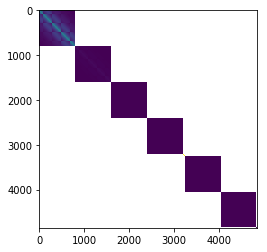

In [12]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v)
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst,struct_dict={gs:grid_groups},sigma_range=6)
cov.to_ascii(os.path.join(working_dir,"prior.cov"))
plt.imshow(np.ma.masked_where(cov.x==0,cov.x))

In [13]:
#par.loc[par.pargp=="pr","partrans"] = "fixed"
#pst.npar_adj

## run pestpp-ies

First let's run without regularization just to see how good we can do...

In [14]:
pst.pestpp_options["ies_subset_size"] = 5
pst.pestpp_options["ies_num_reals"] = 30
pst.pestpp_options["ies_lambda_mults"] = [0.01,1.0,10.0]
pst.pestpp_options["parcov_filename"] = "prior.cov"
pst.pestpp_options["lambda_scale_fac"] = [0.95,1.1]
pst.control_data.noptmax = 4
pst.write(os.path.join(working_dir,pst_name))

noptmax: 4


In [15]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves(".","pestpp-ies",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

# post processing

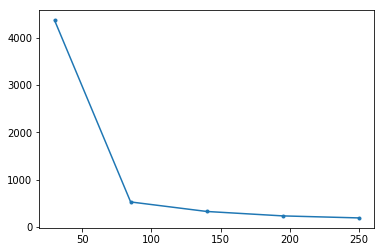

In [16]:
df = pd.read_csv(pst.filename.replace(".pst",".phi.actual.csv"))
plt.plot(df.total_runs,df.loc[:,"mean"],marker='.')
plt.show()

### 1 to 1

<Figure size 576x756 with 0 Axes>

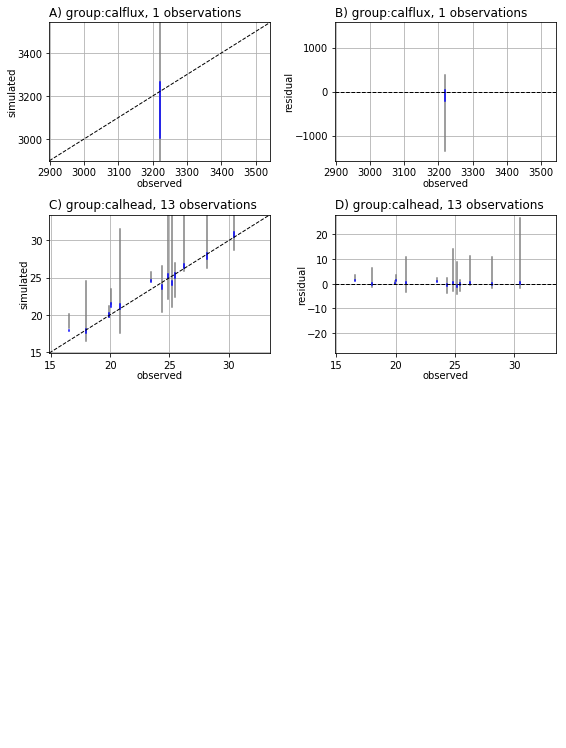

In [17]:
init_obs = pst.filename.replace(".pst",".0.obs.csv")
#pick which interation results to visualize
it = 4
final_obs = init_obs.replace("0","{0}".format(it)) 
init_df = pd.read_csv(init_obs,index_col=0)
init_df.columns = init_df.columns.map(str.lower)
final_df = pd.read_csv(final_obs,index_col=0)
final_df.columns = final_df.columns.map(str.lower)
fig = pyemu.plot_utils.ensemble_res_1to1({'0.5':init_df,"b":final_df},pst=pst)

### forecast posteriors

<Figure size 576x756 with 0 Axes>

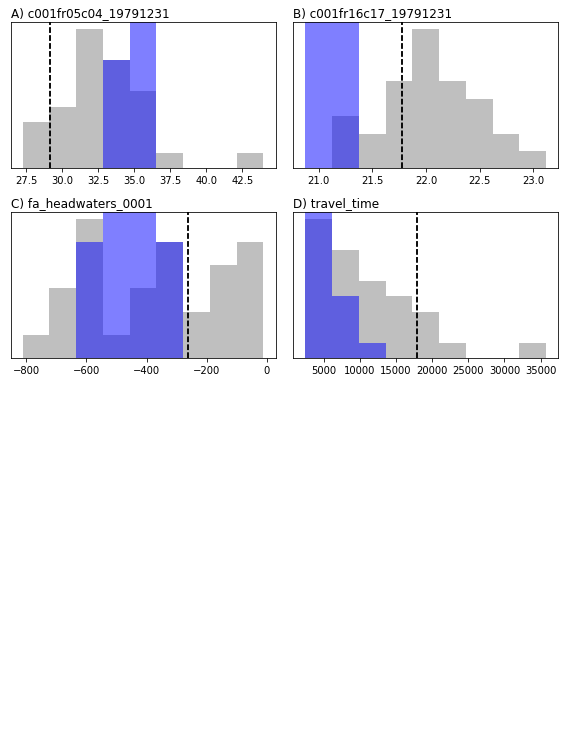

In [18]:
pyemu.plot_utils.ensemble_helper({"0.5":init_df.loc[:,pst.forecast_names],"b":final_df.loc[:,pst.forecast_names]},
                                 deter_vals=pst.observation_data.loc[pst.forecast_names,"obsval"].to_dict(),bins=10,
                                )#deter_range=True,std_window=1)

ruh-roh...

### plot a realization of hk...

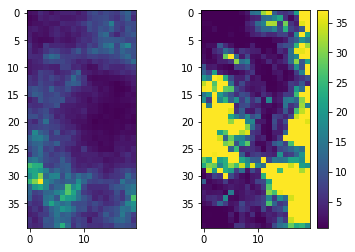

In [19]:
it = 4
realization = "1"
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
par = pst.parameter_data

init_par = pst.filename.replace(".pst",".0.par.csv")
final_par = pst.filename.replace(".pst",".{0}.par.csv".format(it))
init_par = pd.read_csv(init_par,index_col=0)
init_par.columns = init_par.columns.str.lower()
final_par = pd.read_csv(final_par,index_col=0)
final_par.columns = final_par.columns.str.lower()
gr_par = par.loc[par.pargp=="hk",:].copy()
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
gr_par.loc[:,"parval1"] = init_par.loc[realization,gr_par.parnme]
mn,mx = gr_par.parval1.min(),gr_par.parval1.max()
ax1,ax2 = plt.subplot(121),plt.subplot(122)
arr = np.zeros((m.nrow,m.ncol))
arr[gr_par.i,gr_par.j] = gr_par.parval1
c = ax1.imshow(arr,vmin=mn,vmax=mx)
#plt.colorbar(c)
gr_par.loc[:,"parval1"] = final_par.loc[realization,gr_par.parnme]
arr = np.zeros((m.nrow,m.ncol))
arr[gr_par.i,gr_par.j] = gr_par.parval1
c = ax2.imshow(arr,vmin=mn,vmax=mx)
plt.colorbar(c)

## Let's regularize!

In [20]:
pst.pestpp_options["ies_subset_size"] = 4
pst.pestpp_options["ies_lambda_mults"] = [0.1,1.0,10.0]
pst.pestpp_options["lambda_scale_fac"] = [0.5,0.75,1.0]
pst.pestpp_options["parcov_filename"] = "prior.cov"
#pst.pestpp_options["ies_use_prior_scaling"] = True
pst.pestpp_options["ies_reg_factor"] = 0.25
pst.pestpp_options["ies_initial_lambda"] = 5000.0
pst.control_data.noptmax = 4
pst.write(os.path.join(working_dir,pst_name))

noptmax: 4


In [21]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves(".","pestpp-ies",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

### re-post process

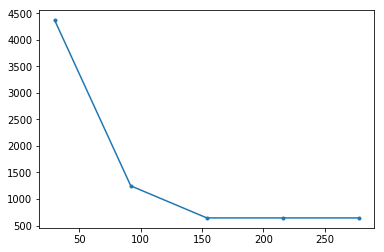

643.69500000000005

In [22]:
df = pd.read_csv(pst.filename.replace(".pst",".phi.actual.csv"))
plt.plot(df.total_runs,df.loc[:,"mean"],marker='.')
plt.show()
df.loc[:,"mean"].min()

<Figure size 576x756 with 0 Axes>

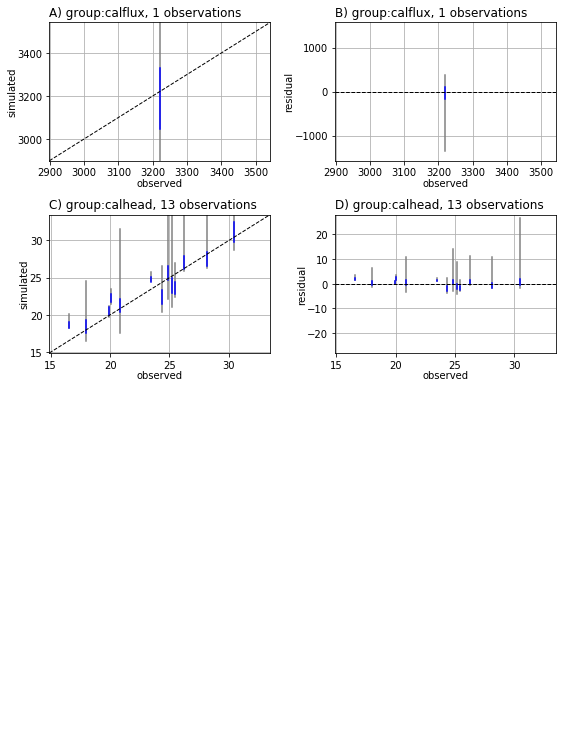

In [23]:
init_obs = pst.filename.replace(".pst",".0.obs.csv")
#pick which interation results to visualize
it = 4
final_obs = init_obs.replace("0","{0}".format(it)) 
init_df = pd.read_csv(init_obs,index_col=0)
init_df.columns = init_df.columns.map(str.lower)
final_df = pd.read_csv(final_obs,index_col=0)
final_df.columns = final_df.columns.map(str.lower)
fig = pyemu.plot_utils.ensemble_res_1to1({'0.5':init_df,"b":final_df},pst=pst)

<Figure size 576x756 with 0 Axes>

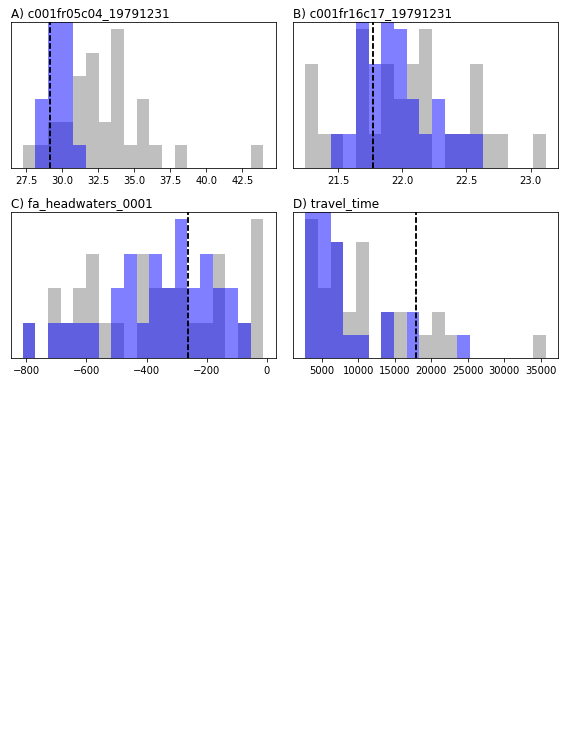

In [24]:
pyemu.plot_utils.ensemble_helper({"0.5":init_df.loc[:,pst.forecast_names],"b":final_df.loc[:,pst.forecast_names]},
                                 deter_vals=pst.observation_data.loc[pst.forecast_names,"obsval"].to_dict(),bins=20,
                                )#deter_range=True,std_window=4.5)

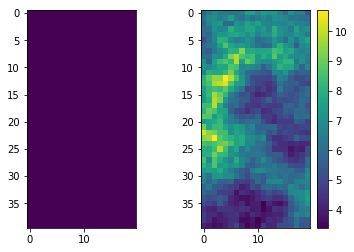

In [30]:
it = 4
realization = "BASE"

m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
par = pst.parameter_data
init_par = pst.filename.replace(".pst",".0.par.csv")
final_par = pst.filename.replace(".pst",".{0}.par.csv".format(it))
init_par = pd.read_csv(init_par,index_col=0)
init_par.columns = init_par.columns.str.lower()
final_par = pd.read_csv(final_par,index_col=0)
final_par.columns = final_par.columns.str.lower()
gr_par = par.loc[par.pargp=="hk",:].copy()
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
gr_par.loc[:,"parval1"] = init_par.loc[realization,gr_par.parnme]
mn,mx = gr_par.parval1.min(),gr_par.parval1.max()
ax1,ax2 = plt.subplot(121),plt.subplot(122)
arr = np.zeros((m.nrow,m.ncol))
arr[gr_par.i,gr_par.j] = gr_par.parval1
c = ax1.imshow(arr,vmin=mn,vmax=mx)
#plt.colorbar(c)
gr_par.loc[:,"parval1"] = final_par.loc[realization,gr_par.parnme]
arr = np.zeros((m.nrow,m.ncol))
arr[gr_par.i,gr_par.j] = gr_par.parval1
c = ax2.imshow(arr)#,vmin=mn,vmax=mx)
plt.colorbar(c)